The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1784, 2017)


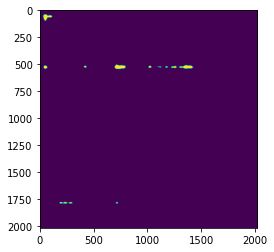

In [40]:
from whiteboard import Whiteboard
from operator import matmul
import skvideo.io  
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, laplace
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil, floor,  pi, sqrt
import imageio as iio
from PIL import Image
from skimage import color
from skimage import io

%load_ext autoreload
%autoreload 2
imgGray = color.rgb2gray(cv2.imread('C:\\Users\\Jaiydev Gupta\\Documents\\5524 project\\cse5524-project\\data\\angle_left.png'))
#imgGray = color.rgb2gray(img)
print(imgGray.shape)
whiteboard = Whiteboard(imgGray)
t = whiteboard.r > 0.005
plt.imshow(t)


4.5168043e-05
-1.920569e-06
4.708861e-05
0.0
R(16:22, 16:22)
[[1.9205679e-06 1.9205672e-06 1.9205677e-06 1.9205681e-06 1.9205675e-06
  1.9205688e-06]
 [1.9205684e-06 1.9205684e-06 1.9205686e-06 1.9205686e-06 1.9205679e-06
  1.9205686e-06]
 [1.9205684e-06 1.9205695e-06 1.9205700e-06 1.9205697e-06 1.9205693e-06
  1.9205697e-06]
 [1.9205681e-06 1.9205697e-06 1.9205709e-06 1.9205704e-06 1.9205702e-06
  1.9205706e-06]
 [1.9205684e-06 1.9205697e-06 1.9205715e-06 1.9205709e-06 1.9205706e-06
  1.9205706e-06]
 [1.9205686e-06 1.9205697e-06 1.9205720e-06 1.9205711e-06 1.9205704e-06
  1.9205702e-06]]


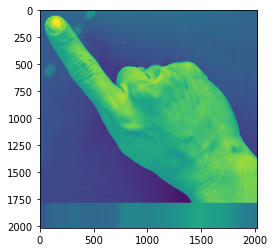

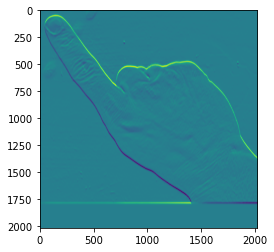

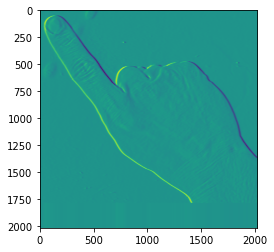

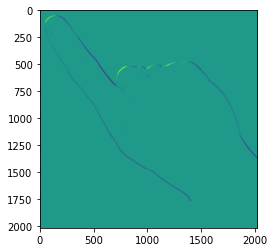

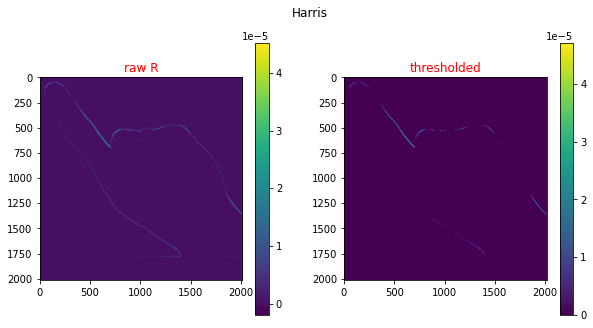

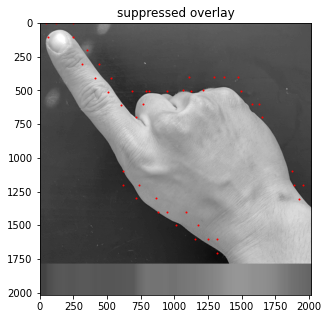

<class 'list'>


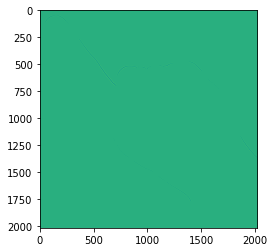

In [5]:
from whiteboard import Whiteboard
from operator import matmul
import skvideo.io  
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, laplace
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import ceil, floor,  pi, sqrt
import imageio as iio
from PIL import Image
from skimage import color
from skimage import io

def gaussDeriv2D(sigma):
    x = np.array(range(0, 6*ceil(sigma)))
    y = np.transpose(x)
    Gx = ((x-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    Gy = ((y-3*ceil(sigma))/(2*pi*sigma**4)) * \
        (np.exp(-(((x-3*ceil(sigma))**2+(y-3*ceil(sigma))**2)/(2*sigma**2))))
    return [Gx, Gy[np.newaxis]]

from skimage.color import rgb2gray
checker = rgb2gray(plt.imread('C:\\Users\\Jaiydev Gupta\\Documents\\5524 project\\cse5524-project\\data\\angle_left.png')[:,:,:3]*255)
checker = np.pad(checker, ((0, np.max(checker.shape) - np.min(checker.shape)), (0, 0)), 'mean')
checker = cv2.GaussianBlur(checker, (3,3), 10)
plt.imshow(checker)
alpha = 0.05
dx, dy = gaussDeriv2D(10)

ix = cv2.filter2D(checker, -1, dx)
iy = cv2.filter2D(checker, -1, dy)
plt.figure()
plt.imshow(ix)
plt.figure()
plt.imshow(iy)

ix2 = np.square(ix)
iy2 = np.square(iy)
ixiy = ix *iy
plt.figure()
plt.imshow(ixiy)

gx = cv2.GaussianBlur(ix2, (3, 3), 1)
gy = cv2.GaussianBlur(iy2, (3, 3), 1)
gxgy = cv2.GaussianBlur(ixiy, (3, 3), 1)

R = gx*gy - np.square(gxgy) - alpha*np.square(gx+gy)
# for some reason I get negative significant values instead of positive?
R = -R
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(R)
plt.colorbar()
plt.gca().set_title('raw R', c='r')
# remove vals less than 1e6
print(np.max(R))
print(np.min(R))
R = R + np.abs(np.min(R))
threshold = np.where(R <1e-5, 0, R)
plt.subplot(1, 2, 2)
plt.imshow(threshold)
plt.colorbar()
print(np.max(threshold))
print(np.min(threshold))
plt.gca().set_title('thresholded', c='r')
print('R(16:22, 16:22)')
print(R[16:22, 16:22])

w_size = 100
suppress = []
im_h, im_w = threshold.shape[:2]

for r in np.arange(im_h - w_size + 1, step=w_size):
    for c in np.arange(im_w - w_size + 1, step=w_size):
        region = threshold[r:r+w_size, c:c+w_size]
        if np.unique(region).size > 0:
            if np.max(np.unique(region)) > 0:
                max_r, max_c = np.unravel_index(np.argmax(np.unique(region)), region.shape)
                suppress.append((c+max_c, r+max_r))

plt.suptitle('Harris')
plt.show()

plt.figure(figsize=(5, 5))
plt.gca().imshow(checker, cmap='gray')
plt.gca().scatter(*zip(*suppress), s=1, c='r')
plt.title('suppressed overlay')
plt.show()

s = 4
sigma = 2**(1/s)
## octave 1
print(type(suppress))
level1 = cv2.GaussianBlur(threshold, (3,3), sigma)
level2 = cv2.GaussianBlur(level1, (3,3), sigma)
level3 = cv2.GaussianBlur(level2, (3,3), sigma)
level4 = cv2.GaussianBlur(level3, (3,3), sigma)
log1 = level2 - level1
log2 = level3 -level2
log3 = level4 - level3

def findMax(log2, y ,x):
    point1 = log2[y][x]
    point2 = log2[y-1][x]
    point3 = log2[y+1][x]
    point4 = log2[y][x+1]
    point5 = log2[y][x-1]
    point6 = log2[y-1][x-1]
    point7= log2[y-1][x+1]
    point8 = log2[y+1][x+1]
    point9 = log2[y+1][x-1]
    a= [point1,point2,point3,point4,point5,point6,point7,point8,point9]
    return max(a)

l,w = log2.shape    
octave0 = np.zeros(l,w)
for y in range(1,len(log2)-1):
    for x in range(1, len(log2[0])-1):
        log2Max = findMax(log2,y,x)
        log2Max = max(log2Max,findMax(log1,y,x))
        log2Max = max(log2Max,findMax(log3,y,x))
        octave0[y][x] = log2Max
        

 
## octave2
DownOtave2 = level1
np.delete(DownOtave2, list(range(0, DownOtave2.shape[0], 2)), axis=0)
np.delete(DownOtave2, list(range(0, DownOtave2.shape[0], 2)), axis=1)
scaledDown1 = cv2.GaussianBlur(DownOtave2, (3,3), sigma)
scaledDown2 = cv2.GaussianBlur(scaledDown1, (3,3), sigma)
scaledDown3 = cv2.GaussianBlur(scaledDown2, (3,3), sigma)
scaledDown4 = cv2.GaussianBlur(scaledDown3, (3,3), sigma)
scalledDownlog1 = scaledDown2 - scaledDown1
scalledDownlog2 = scaledDown3 - scaledDown2
scalledDownlog3 = scaledDown4 - scaledDown3

## octave3
DownOctave3 = scaledDown1
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=0)
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=1)
scaledDown1 = cv2.GaussianBlur(DownOctave3, (3,3), sigma)
scaledDown2 = cv2.GaussianBlur(scaledDown1, (3,3), sigma)
scaledDown3 = cv2.GaussianBlur(scaledDown2, (3,3), sigma)
scaledDown4 = cv2.GaussianBlur(scaledDown3, (3,3), sigma)
DownOctave3log1 = scaledDown2 - scaledDown1
DownOctave3log2 = scaledDown3 - scaledDown2
DownOctave3log3 = scaledDown4 - scaledDown3

## octave4
DownOctave4 = scaledDown1
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=0)
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=1)
scaledDown1 = cv2.GaussianBlur(DownOctave3, (3,3), sigma)
scaledDown2 = cv2.GaussianBlur(scaledDown1, (3,3), sigma)
scaledDown3 = cv2.GaussianBlur(scaledDown2, (3,3), sigma)
scaledDown4 = cv2.GaussianBlur(scaledDown3, (3,3), sigma)
DownOctave4log1 = scaledDown2 - scaledDown1
DownOctave4log2 = scaledDown3 - scaledDown2
DownOctave4log3 = scaledDown4 - scaledDown3

## octave5
DownOctave5 = scaledDown1
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=0)
np.delete(DownOctave3, list(range(0, DownOctave3.shape[0], 2)), axis=1)
scaledDown1 = cv2.GaussianBlur(DownOctave3, (3,3), sigma)
scaledDown2 = cv2.GaussianBlur(scaledDown1, (3,3), sigma)
scaledDown3 = cv2.GaussianBlur(scaledDown2, (3,3), sigma)
scaledDown4 = cv2.GaussianBlur(scaledDown3, (3,3), sigma)
DownOctave5log1 = scaledDown2 - scaledDown1
DownOctave5log2 = scaledDown3 - scaledDown2
DownOctave5log3 = scaledDown4 - scaledDown3





#plt.imshow(level1)
# plt.imshow(level2)
plt.imshow(log1)
plt.show()
